In [43]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Paths to the directories
base_dir = 'instruments-aug-np/'
categories = ['clap', 'hihat', 'kick', 'snare']

target_length = 10000

# Load Data function
def load_data(base_dir, categories, target_length=target_length):  # Change target length to 10000
    data = []
    labels = []
    
    for idx, category in enumerate(categories):
        category_path = os.path.join(base_dir, category)
        for file in os.listdir(category_path):
            if file.endswith('.npy'):
                file_path = os.path.join(category_path, file)
                npy_file = np.load(file_path)
                data.append(npy_file)
                labels.append(idx)

    # Pad all data to the target_length
    padded_data = []
    for npy_file in data:
        if len(npy_file) < target_length:
            # Pad with zeros to match target_length
            padded_file = np.pad(npy_file, (0, target_length - len(npy_file)), mode='constant')
        else:
            # Truncate if the file is longer than target_length
            padded_file = npy_file[:target_length]
        padded_data.append(padded_file)

    return np.array(padded_data), np.array(labels)

In [44]:
# Load the data and corresponding labels
X, y = load_data(base_dir, categories)

# Normalize the data
X = X / np.max(X)

# One-hot encode the labels
y = to_categorical(y, num_classes=len(categories))

# Train-Validation-Test Split (70-10-20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)

# Reshape data for 1D CNN (keeping the input as sequences, no need to reshape into 2D)
X_train = X_train.reshape(-1, target_length , 1)
X_val = X_val.reshape(-1, target_length, 1)
X_test = X_test.reshape(-1, target_length, 1)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (3819, 10000, 1)
X_val shape: (540, 10000, 1)
X_test shape: (1098, 10000, 1)


In [30]:

# Define the 1D CNN model in TensorFlow
model = Sequential()

# Add 1D Conv layer
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(24384, 1)))
model.add(MaxPooling1D(pool_size=2))

# Add more 1D Conv layers
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output
model.add(Flatten())

# Fully connected Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer for the 4 classes
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

/Users/sahil/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 38190
'y' sizes: 3819


In [37]:
import time
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Predict on X_test and measure accuracy without timing
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Step 2: Class-wise accuracy (without timing)
class_wise_report = classification_report(y_true, y_pred, target_names=categories, output_dict=True)

print("\nClass-wise Accuracy:")
for label, metrics in class_wise_report.items():
    if isinstance(metrics, dict):
        print(f"Class: {label}, Accuracy: {metrics['precision']:.4f}")

# Step 3: Time-based metrics (class-wise and overall prediction time)
class_times = {i: [] for i in range(len(categories))}  # Dictionary to store times for each class

total_time = 0
for i in range(len(X_test)):
    sample = X_test[i:i+1]  # Extract individual sample
    label = y_true[i]
    
    # Measure the time to predict the most likely class for a single sample
    sample_start_time = time.time()
    pred = model.predict(sample)  # Predict the most likely class
    sample_end_time = time.time()
    
    # Record time taken for this sample
    sample_time = sample_end_time - sample_start_time
    total_time += sample_time
    class_times[label].append(sample_time)

# Step 4: Average prediction time per sample (overall)
average_time_per_sample = total_time / len(X_test)
print(f"\nAverage time for prediction per sample overall: {average_time_per_sample:.6f} seconds")

# Step 5: Class-wise average prediction time
print("\nClass-wise Average Prediction Time per Sample:")
for class_label, times in class_times.items():
    avg_time_class = np.mean(times)
    print(f"Class: {categories[class_label]}, Average Time: {avg_time_class:.6f} seconds")


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_8" is incompatible with the layer: expected axis -1 of input shape to have value 389888, but received input with shape (32, 15744)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 1000, 1), dtype=float32)
  • training=False
  • mask=None

In [45]:
## Simplifying model

tiny_model = Sequential()

# Add fewer filters in Conv1D layers
tiny_model.add(Conv1D(4, kernel_size=3, activation='relu'))
tiny_model.add(MaxPooling1D(pool_size=2))

# Add only one more Conv1D layer
tiny_model.add(Conv1D(8, kernel_size=3, activation='relu'))
tiny_model.add(MaxPooling1D(pool_size=2))

# Flatten the output
tiny_model.add(Flatten())

# Fully connected Dense layers with reduced neurons
# tiny_model.add(Dense(32, activation='relu'))
# tiny_model.add(Dropout(0.2))

# Output layer for the 4 classes
tiny_model.add(Dense(4, activation='softmax'))

# Compile the tiny_model
tiny_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = tiny_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate on the test set
test_loss, test_acc = tiny_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5195 - loss: 1.1118 - val_accuracy: 0.8259 - val_loss: 0.5632
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8876 - loss: 0.4249 - val_accuracy: 0.9093 - val_loss: 0.2809
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9444 - loss: 0.2210 - val_accuracy: 0.9611 - val_loss: 0.1448
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9692 - loss: 0.1275 - val_accuracy: 0.9741 - val_loss: 0.1018
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9747 - loss: 0.0949 - val_accuracy: 0.9870 - val_loss: 0.0691
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9800 - loss: 0.0726 - val_accuracy: 0.9796 - val_loss: 0.0605
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9875 - loss: 0.0561 - val_accuracy: 0.9852 - val_loss: 0.0445
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9895 - loss: 0.0379 - val_accu

In [40]:
# Step 1: Predict on X_test and measure accuracy without timing
y_pred_probs = tiny_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Step 2: Class-wise accuracy (without timing)
class_wise_report = classification_report(y_true, y_pred, target_names=categories, output_dict=True)

print("\nClass-wise Accuracy:")
for label, metrics in class_wise_report.items():
    if isinstance(metrics, dict):
        print(f"Class: {label}, Accuracy: {metrics['precision']:.4f}")

# Step 3: Time-based metrics (class-wise and overall prediction time)
class_times = {i: [] for i in range(len(categories))}  # Dictionary to store times for each class

total_time = 0
for i in range(len(X_test)):
    sample = X_test[i:i+1]  # Extract individual sample
    label = y_true[i]
    
    # Measure the time to predict the most likely class for a single sample
    sample_start_time = time.time()
    pred = tiny_model.predict(sample)  # Predict the most likely class
    sample_end_time = time.time()
    
    # Record time taken for this sample
    sample_time = sample_end_time - sample_start_time
    total_time += sample_time
    class_times[label].append(sample_time)

# Step 4: Average prediction time per sample (overall)
average_time_per_sample = total_time / len(X_test)
print(f"\nAverage time for prediction per sample overall: {average_time_per_sample:.6f} seconds")

# Step 5: Class-wise average prediction time
print("\nClass-wise Average Prediction Time per Sample:")
for class_label, times in class_times.items():
    avg_time_class = np.mean(times)
    print(f"Class: {categories[class_label]}, Average Time: {avg_time_class:.6f} seconds")


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Overall Accuracy: 0.8297

Class-wise Accuracy:
Class: clap, Accuracy: 0.5260
Class: hihat, Accuracy: 0.9899
Class: kick, Accuracy: 0.9347
Class: snare, Accuracy: 0.8843
Class: macro avg, Accuracy: 0.8337
Class: weighted avg, Accuracy: 0.8784
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━

In [10]:
X_test.shape

(1098, 24384, 1)

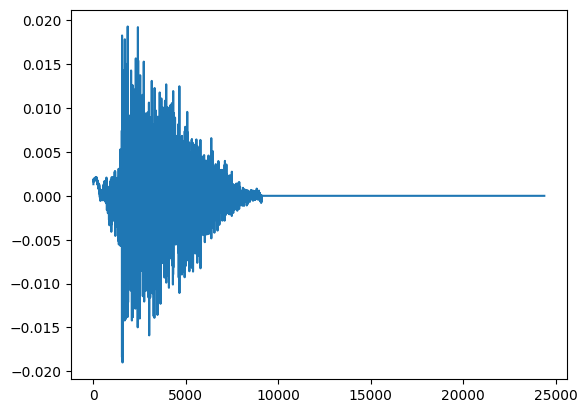

In [17]:
import matplotlib.pyplot as plt

plt.plot(X_test[160,:,0])


In [50]:

# Now we will convert the trained model to INT8 using TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(tiny_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Provide a representative dataset for INT8 quantization
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [input_value]

# Set representative dataset for INT8 calibration
converter.representative_dataset = representative_data_gen

# Ensure the model uses INT8 for both input and output
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert the model to TensorFlow Lite format
tflite_model = converter.convert()

# Save the quantized model to a file
with open('model_quantized_int8.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model has been successfully quantized to INT8.")

# To run inference using TensorFlow Lite with the INT8 quantized model

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model with one sample from the test set (INT8 input)
tlist = []

for i in range(len(X_test)):
    t1 = time.time()
    input_data = np.expand_dims(X_test[i].astype(np.int8), axis=0)  # INT8 input
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run the model
    interpreter.invoke()

    # Get the predicted output (INT8 output)
    output_data = interpreter.get_tensor(output_details[0]['index'])
    # print(f"Predicted output (INT8): {output_data}")
    t2=time.time()
    tlist.append(t2-t1)

tlist = np.array(tlist)
print(tlist.mean())
print(tlist.std()/tlist.mean())


INFO:tensorflow:Assets written to: /var/folders/cw/grqr2sbs4zzbfgmvt0yhcmrm0000gp/T/tmptq7xleeb/assets


INFO:tensorflow:Assets written to: /var/folders/cw/grqr2sbs4zzbfgmvt0yhcmrm0000gp/T/tmptq7xleeb/assets


Saved artifact at '/var/folders/cw/grqr2sbs4zzbfgmvt0yhcmrm0000gp/T/tmptq7xleeb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10000, 1), dtype=tf.float32, name='keras_tensor_306')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  6411460848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5772114224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14540657936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5868557056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6414128048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5832178496: TensorSpec(shape=(), dtype=tf.resource, name=None)


/Users/sahil/Library/Python/3.9/lib/python/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1726357819.012191 4617559 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1726357819.012204 4617559 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-09-14 19:50:19.012494: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/cw/grqr2sbs4zzbfgmvt0yhcmrm0000gp/T/tmptq7xleeb
2024-09-14 19:50:19.013009: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-09-14 19:50:19.013014: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/cw/grqr2sbs4zzbfgmvt0yhcmrm0000gp/T/tmptq7xleeb
2024-09-14 19:50:19.015839: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-09-14 19:50:19.031962: I tensorflow/cc

Model has been successfully quantized to INT8.
0.0001746956767931662
0.05532709429752243
